In [1]:
import os
import numpy as np
path = os.getcwd()
import matplotlib as mpl
import pyvista as pv
from pyvista import CellType
from ansys.mapdl.core import launch_mapdl

In [2]:
mapdl = launch_mapdl(run_location = path)

In [3]:
mapdl.clear()
mapdl.prep7()
mapdl.et(1,188)
mapdl.mp('ex',1,1e7)

#mapdl.sectype(1,'beam','rect')
#mapdl.secdata(1,3,2,2)
#mapdl.sectype(1,'beam','L')
#mapdl.secdata(2,4,.25,.5)
mapdl.sectype(1,'beam','chan')
mapdl.secdata(2,3,1,.1,.1,.1)
mapdl.secoffset('origin')

mapdl.n(1,0,0,0)
mapdl.n(2,10,0,0)
mapdl.n(3,20,0,0)
mapdl.n(4,40,0,0)
mapdl.n(5,0,1,0)

mapdl.e(1,2,5)
mapdl.e(2,3,5)
mapdl.e(3,4,5)

3

In [4]:
secdata = mapdl.slist(1,1,1,'full')

file = open("sectionnodes.txt", "w")
file.write(secdata)
file.close()

In [5]:
line_total = 0
start_node = 0
end_node = 0

file = open("sectionnodes.txt", "r")
for line in file:
    line_total += 1
    if line.startswith("    Node Number"):
        start_node = line_total 
    if line.startswith("    Beam Section Cell Connectivity"):
        end_node = line_total - 2
    if line.startswith("    Cell Number"):
        start_cell = line_total + 1
    if line.startswith("    Int. Pt. Number"):
        end_cell = line_total - 5    
file.close()
print(line_total, start_node, end_node)

137 35 86


In [6]:
section_nodes = np.genfromtxt("sectionnodes.txt", skip_header=start_node, max_rows = end_node - start_node)

In [7]:
#section_nodes

In [8]:
section_cells = np.genfromtxt("sectionnodes.txt", skip_header=start_cell, max_rows = end_cell - start_cell)

In [9]:
#section_cells

In [10]:
beam_elements = len(mapdl.mesh.enum)
#beam_elements

In [11]:
offset = np.array([])
cell_type = np.array([])
index = 0
cells_pv = np.array([])
cn_global = np.array([])
cn_index = 0
for element in range(1, beam_elements+1):
    cn = np.array([])
    for cell in range(0, len(section_cells)):
        index +=1
        n1 = int(section_cells[cell,1])
        n2 = int(section_cells[cell,2])
        n3 = int(section_cells[cell,3])
        n4 = int(section_cells[cell,4])
        
        node_i = mapdl.queries.nelem(element,2)
        node_j = mapdl.queries.nelem(element,1)
        node_k = mapdl.queries.nelem(element,3)
        
        mapdl.cs(11,0,node_i,node_j,node_k)
        mapdl.csys(11)
        node_i_x = mapdl.queries.nx(node_i)
        node_j_x = mapdl.queries.nx(node_j)
        mapdl.csys(0)
    
        cn = np.append(cn, [[node_i_x], [section_nodes[n1-1,2]], [section_nodes[n1-1,1]]])
        cn = np.append(cn, [[node_i_x], [section_nodes[n2-1,2]], [section_nodes[n2-1,1]]])
        cn = np.append(cn, [[node_i_x], [section_nodes[n3-1,2]], [section_nodes[n3-1,1]]])
        cn = np.append(cn, [[node_i_x], [section_nodes[n4-1,2]], [section_nodes[n4-1,1]]])
        cn = np.append(cn, [[node_j_x], [section_nodes[n1-1,2]], [section_nodes[n1-1,1]]])
        cn = np.append(cn, [[node_j_x], [section_nodes[n2-1,2]], [section_nodes[n2-1,1]]])
        cn = np.append(cn, [[node_j_x], [section_nodes[n3-1,2]], [section_nodes[n3-1,1]]])
        cn = np.append(cn, [[node_j_x], [section_nodes[n4-1,2]], [section_nodes[n4-1,1]]])
        
        cn = np.reshape(cn,(-1,3))
        cells_pv = np.append(cells_pv,[8,(8*cn_index)+(8*cell),(8*cn_index)+(8*cell)+1,(8*cn_index)+(8*cell)+2,
                                       (8*cn_index)+(8*cell)+3,(8*cn_index)+(8*cell)+4,(8*cn_index)+(8*cell)+5,
                                       (8*cn_index)+(8*cell)+6,(8*cn_index)+(8*cell)+7])
        
        cell_type = np.append(cell_type,[CellType.HEXAHEDRON])
        offset = np.append(offset, [(index-1)*9])
    cn_index += len(section_cells)
    mapdl.parameters["cn"] = cn
    mapdl.vfun('cnglobal', 'global', 'cn(1,1)',11)
    temp = mapdl.parameters["cnglobal"]
    if element == 1:
        cn_global = temp
    else:
        cn_global = np.vstack((cn_global, temp)).astype(float)
cells_pv = cells_pv.astype(int)
#print(cells_pv)

In [12]:
grid = pv.UnstructuredGrid(cells_pv, cell_type, cn_global)

In [13]:
mapdl.finish()
mapdl.slashsolu()
mapdl.d(1,'all',0)
mapdl.f(4,'fx',100)
mapdl.f(4,'mz',100)
mapdl.solve()
mapdl.finish()

FINISH SOLUTION PROCESSING


 ***** ROUTINE COMPLETED *****  CP =         0.859

In [14]:
mapdl.post1()
mapdl.set('last')

USE LAST SUBSTEP ON RESULT FILE  FOR LOAD CASE 0 

 SET COMMAND GOT LOAD STEP=     1  SUBSTEP=     1  CUMULATIVE ITERATION=     1
   TIME/FREQUENCY=  1.0000    
 TITLE=

In [15]:
scalars = []
for element in range(1, beam_elements+1):
    for cell in range(0, len(section_cells)):
        n1 = int(section_cells[cell,1])
        n2 = int(section_cells[cell,2])
        n3 = int(section_cells[cell,3])
        n4 = int(section_cells[cell,4])
        scalars.append(mapdl.get_value('secr',element,'s','eqv','ival',n1))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','ival',n2))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','ival',n3))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','ival',n4))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','jval',n1))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','jval',n2))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','jval',n3))
        scalars.append(mapdl.get_value('secr',element,'s','eqv','jval',n4))


D:\PyMAPDL-AFT\venv\lib\site-packages\ansys\mapdl\core\_commands\graphics_\style.py:271: UserWarning: pymapdl does not support /ESHAPE when plotting in Python using ``mapdl.eplot()``.  Use ``mapdl.eplot(vtk=False)`` 
  warnings.warn(


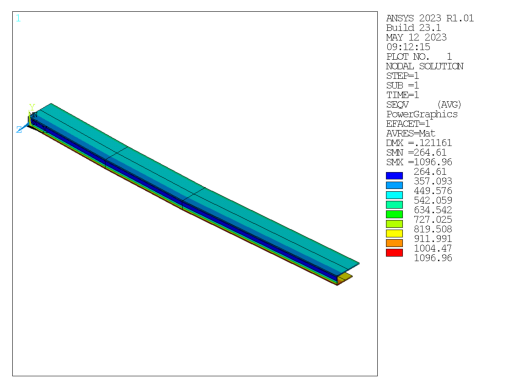

<Figure size 640x480 with 0 Axes>

/SHOW SWITCH PLOTS TO  PNG         - RASTER MODE.

<Figure size 640x480 with 0 Axes>

In [16]:
mapdl.graphics('power')
mapdl.rgb('INDEX',100,100,100, 0)   
mapdl.rgb('INDEX', 80, 80, 80,13)   
mapdl.rgb('INDEX', 60, 60, 60,14)  
mapdl.rgb('INDEX', 0, 0, 0,15)  

mapdl.view(1,1,1,1)
mapdl.edge(1,1)
mapdl.eshape(1)
mapdl.show('png')
mapdl.plnsol('s','eqv')
mapdl.show('')

In [17]:
cmap1 = (mpl.colors.ListedColormap(['blue','royalblue', 'cyan', '#00FA9A','#7CFC00', '#ADFF2F','yellow', 'orange','red'])
        .with_extremes())

In [18]:
_ = grid.plot(scalars = scalars, show_edges=True, cmap=cmap1,background = 'white',scalar_bar_args = {
    "color": "black",
    "title": "Expanded Beam SEQV",
    "vertical": False,
    "n_labels": 10,})

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [19]:
mapdl.exit()